In [1]:
import sys
sys.path.append("../../src/other_methods")
sys.path.append("../..")

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
from PMMR.data_class import PVTrainDataSet, PVTestDataSet
from PMMR.pmmr import PMMRModelV2
from src.generate_experiment_data import read_legalized_abortion_and_crime_dataset
from src.utils.ml_utils import data_transform

In [4]:
data_path = '../../data/abortion'
return_test = False
seed = 9
W, Z, A, Y, do_A, EY_do_A = read_legalized_abortion_and_crime_dataset(data_path, return_test, seed)

A_transformed, A_transformer = data_transform(A)
Z_transformed, Z_transformer = data_transform(Z)
W_transformed, W_transformer = data_transform(W)
Y_transformed, Y_transformer = data_transform(Y)

data_size = A_transformed.shape[0]
A_transformed = np.array(A_transformed).reshape(data_size, -1)
Z_transformed = np.array(Z_transformed).reshape(data_size, -1)
W_transformed = np.array(W_transformed).reshape(data_size, -1)
Y_transformed = np.array(Y_transformed).reshape(data_size, -1)

train_dataset = PVTrainDataSet( treatment = A_transformed,
                                treatment_proxy = Z_transformed,
                                outcome_proxy = W_transformed,
                                outcome = Y_transformed,
                                backdoor = None)


test_dataset = PVTestDataSet(treatment = do_A,
                             structural = EY_do_A)

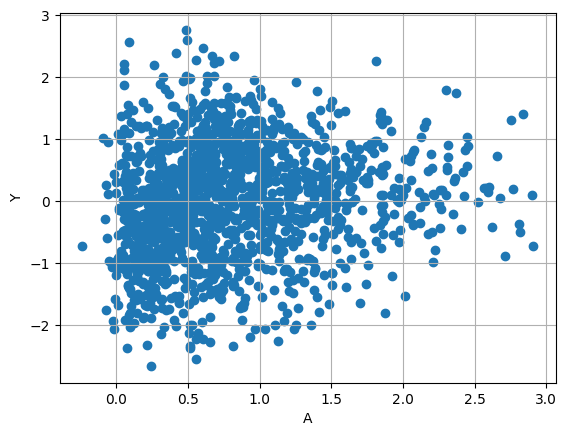

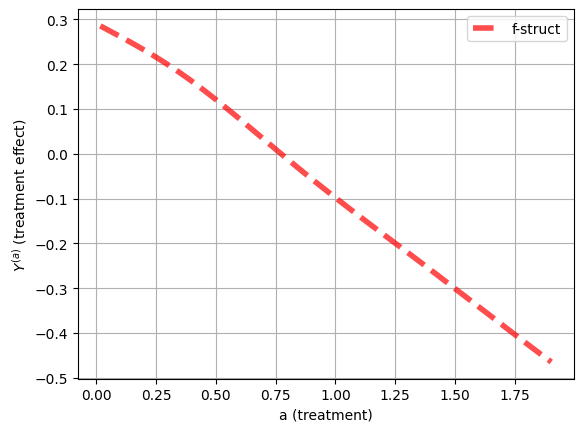

In [5]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()

Structured function test set MSE: 0.04784762700154218
Structured function test set MAE: 0.18580490403701116


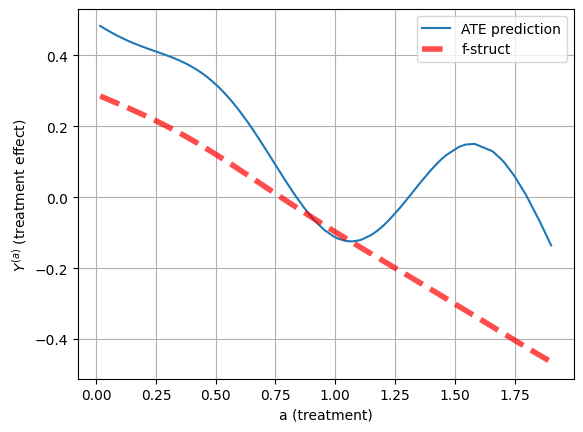

In [7]:
model = PMMRModelV2(lam1 = 1e-5, lam2 = 1e-5)

model.fit(train_dataset, "abortion_data")
do_A_size = do_A.shape[0]
do_A_transformed = (A_transformer.transform(do_A.reshape(-1, 1))).reshape(do_A_size, -1)
f_struct_pred_transformed = model.predict(do_A_transformed)
f_struct_pred = Y_transformer.inverse_transform(f_struct_pred_transformed.reshape(do_A_size, -1)).reshape(do_A_size, -1)

structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))

print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))

plt.plot(do_A, f_struct_pred, label = "ATE prediction")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha = 0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()